In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Compose, PILToTensor, ToTensor
import PIL
import torch
import torchvision as torchvision

from dataset import CropSegmentationDataset
from am4ip.new_trainer import BaselineTrainer

from torch.utils.data import DataLoader

from unet_model import UNet

In [2]:
batch_size = 11
lr = 1e-4
epoch = 60

In [3]:
transform = Compose([lambda z: z.resize((256,256),PIL.Image.BILINEAR), 
                     PILToTensor(),
                     lambda z: z.to(dtype=torch.float32) / 127.5 - 1  # Normalize between -1 and 1
                     ])

target_transform = Compose([lambda z: z.resize((256,256),PIL.Image.NEAREST),
                            PILToTensor(),
                            lambda z : z.to(dtype=torch.int64).squeeze(0)
                     ])

In [4]:
dataset_train = CropSegmentationDataset(set_type="train", transform=transform, target_transform = target_transform, remove_small_items = True, merge_small_items=False)
dataset_test = CropSegmentationDataset(set_type="test", transform = transform, merge_small_items=False )
dataset_val = CropSegmentationDataset(set_type="val", target_transform = target_transform, transform = transform, remove_small_items = True, merge_small_items=False)

In [5]:
#model = UNet(n_channels=3, n_classes=3)
model = torch.load('unet_results/unet_epoch_20.pt')

In [6]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
trainer = BaselineTrainer(model=model, loss = loss, optimizer=optimizer)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
history = trainer.fit(train_loader, val_loader, epoch=epoch)

Start epoch 1/60
Validation 39/39: loss = 0.051745852025655665
Start epoch 2/60
Validation 39/39: loss = 0.049468756295167485
Start epoch 3/60
Validation 39/39: loss = 0.047775558745249726
Start epoch 4/60
Validation 39/39: loss = 0.047508867027667855
Start epoch 5/60
Validation 39/39: loss = 0.047524481343153194
Start epoch 6/60
Validation 39/39: loss = 0.047398993315605015
Start epoch 7/60
Validation 39/39: loss = 0.045711321517443046
Start epoch 8/60
Validation 39/39: loss = 0.044340990961362154
Start epoch 9/60
Validation 39/39: loss = 0.042623435266506986
Start epoch 10/60
Validation 39/39: loss = 0.042068657107078114
Start epoch 11/60
Validation 39/39: loss = 0.040564835596925176
Start epoch 12/60
Validation 39/39: loss = 0.041504050294558205
Start epoch 13/60
Validation 39/39: loss = 0.040587325556538045
Start epoch 14/60
Validation 39/39: loss = 0.039902241279681526
Start epoch 15/60
Validation 39/39: loss = 0.039496396453334734
Start epoch 16/60
Validation 39/39: loss = 0.0384

In [8]:
import pickle
with open('history_unet80epoch.pkl', 'wb') as file:
    pickle.dump(history, file)

In [10]:
val_loss_history = history['val_loss']
val_accuracy_history = history['val_accuracy']
train_loss_history = history['train_loss']
train_accuracy_history = history['train_accuracy']

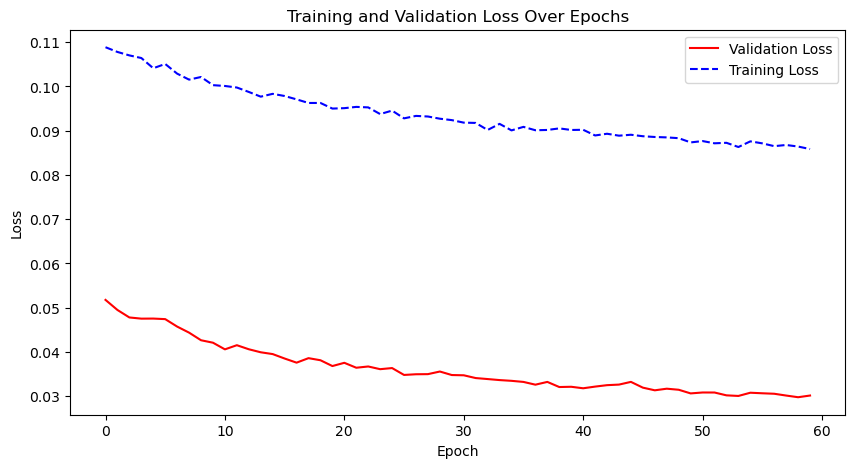

In [11]:
# Courbe de perte de validation
plt.figure(figsize=(10, 5))
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.plot(train_loss_history, label='Training Loss', color='blue', linestyle='dashed')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_unet_80epoch.png')
plt.show()

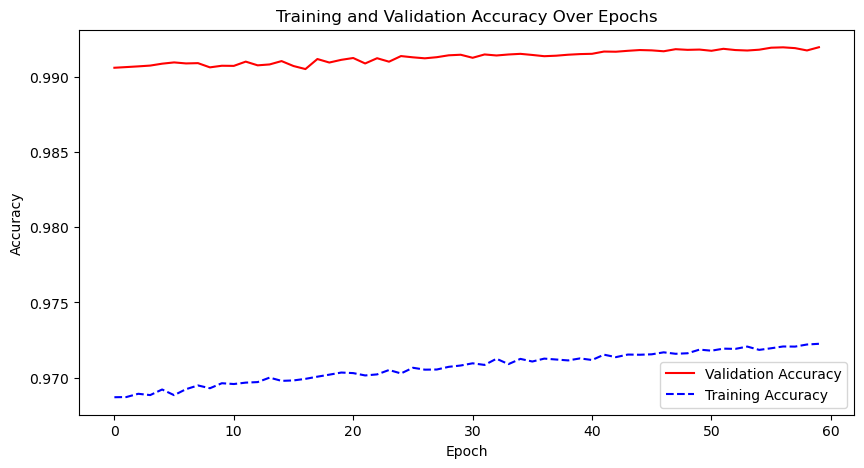

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy_history, label='Validation Accuracy', color='red')
plt.plot(train_accuracy_history, label='Training Accuracy', color='blue', linestyle='dashed')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_unet_80epoch.png')
plt.show()

In [24]:
#torch.save(model, 'unet80epoch.pt')
model = torch.load('unet_results/unet_epoch_30.pt')
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
trainer = BaselineTrainer(model=model, loss = loss, optimizer=optimizer)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

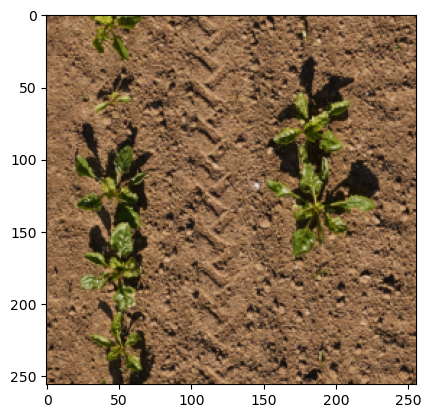

In [25]:
t0 = dataset_val[16]
i_drone = (t0[0].permute(1,2,0)+1) * 0.5
plt.imshow(i_drone)

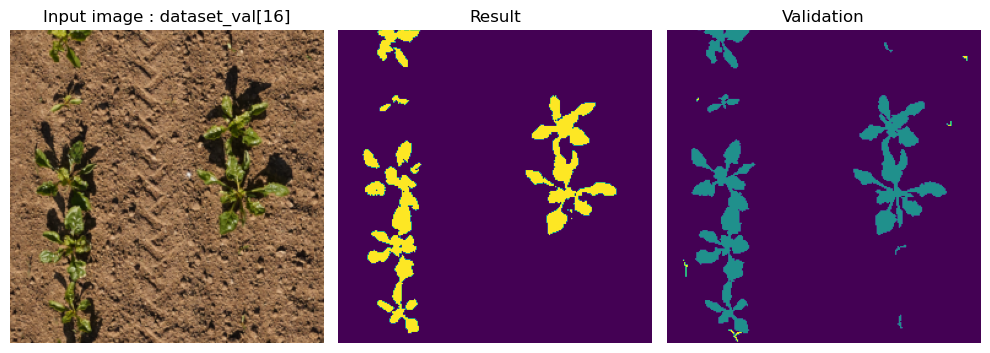

In [26]:
test = trainer.model.forward(t0[0].unsqueeze(0).cuda())
test = test.cpu().detach()
test1 = test.squeeze(0)
i = torch.softmax(test1, 0)
i_merged = torch.stack([i[0], i[1], i[2]])
i_result = torch.argmax(i_merged, dim=0)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(i_drone)
axes[0].set_title('Input image : dataset_val[16]')
axes[0].axis('off')
axes[1].imshow(i_result)
axes[1].set_title('Result')
axes[1].axis('off')
axes[2].imshow(np.array(t0[1]).squeeze())
axes[2].set_title('Validation')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('result_unet_30epoch.png')
plt.show()